# AutoRegressive techniques in Python

Starter notebook to do some basic stuff with [statsmodels](https://www.statsmodels.org/stable/index.html) in Python for finance analysts who are new to Python data analysis. I won't explain all of the python syntax but just demonstrate bare minimum required to:

0. Import data in from excel
1. Run a simple linear regression with `Statsmodels`
2. Run an AutoRegression
3. Run a Vector AutorRegression

### Reference: 

* [Statsmodels documentation](https://www.statsmodels.org/stable/index.html)

## First: Import some libraries

In [205]:
import pandas as pd
import statsmodels.api as sm

# plotting
import seaborn as sns
sns.set()  # set the default plotting backend to seaborn

## Load Data

For the purposes of this demo we'll use a built-in dataset.

In [70]:
# Load Data
longley = sm.datasets.longley.load_pandas()
# Convert to dataframe to keep it simple
df = longley.data

This classic dataset of labor statistics was one of the first used to test the accuracy of least squares computations. The response variable (y) is the Total Derived Employment and the predictor variables are GNP Implicit Price Deflator with Year 1954 = 100 (x1), Gross National Product (x2), Unemployment (x3), Size of Armed Forces (x4), Non-Institutional Population Age 14 & Over (x5), and Year (x6). [Source](https://www.itl.nist.gov/div898/strd/lls/data/LINKS/i-Longley.shtml)

## Side Note: If you want to load in your own data

If you want to load in your own data, I'd recommend two options:

### Option 1. Load from an excel file in the current directory

```python
df = pd.read_excel("filename.xlsx")
```

### Option 2. Copy from your clipboard

A simpler alternative, especially if you're new to python, is that you can use a method called `read_clipboard()` that might work for you. In your excel file, simply highlight the data table you want to use and copy it with Ctrl+V, and then switch to your jupyter notebook and enter:

```python
df = pd.read_clipboard()
```

If it doesn't work, you may need to reformat your data in excel. 

In [71]:
# see dataframe representation
df.head()

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,60323.0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,61122.0,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,60171.0,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,61187.0,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,63221.0,96.2,328975.0,2099.0,3099.0,112075.0,1951.0


# EDA, Plotting

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'A simple plot'}, xlabel='GNP', ylabel='TOTEMP'>

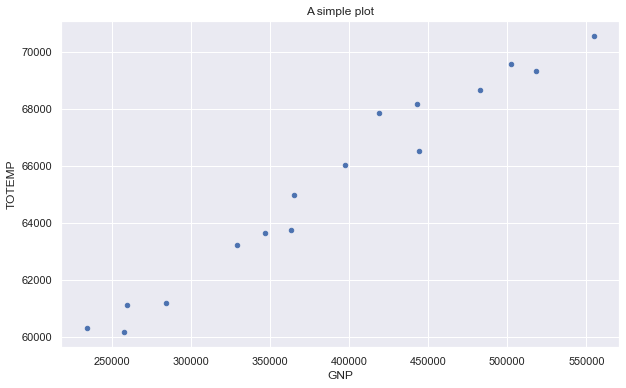

In [260]:
# Here we will use seaborn to perform some simple plotting
df.plot(x="GNP", y="TOTEMP", kind="scatter", title="A simple plot", figsize=(10,6))

In [261]:
df.describe()

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,65317.000000,101.681250,387698.437500,3193.312500,2606.687500,117424.000000,1954.500000
std,3511.968356,10.791553,99394.937795,934.464247,695.919604,6956.101561,4.760952
min,60171.000000,83.000000,234289.000000,1870.000000,1456.000000,107608.000000,1947.000000
25%,62712.500000,94.525000,317881.000000,2348.250000,2298.000000,111788.500000,1950.750000
50%,65504.000000,100.600000,381427.000000,3143.500000,2717.500000,116803.500000,1954.500000
75%,68290.500000,111.250000,454085.500000,3842.500000,3060.750000,122304.000000,1958.250000
max,70551.000000,116.900000,554894.000000,4806.000000,3594.000000,130081.000000,1962.000000


array([[<AxesSubplot:title={'center':'TOTEMP'}>]], dtype=object)

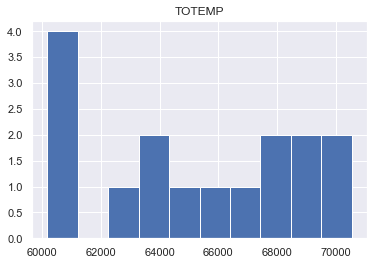

In [263]:
# look at distributions
df.hist('TOTEMP')

### Correlation heatmap

You can easily find the correlation values in a dataframe with the `.corr()` method.

In [264]:
df.corr()

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
TOTEMP,1.000000,0.970899,0.983552,0.502498,0.457307,0.960391,0.971329
GNPDEFL,0.970899,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.983552,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.502498,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.457307,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.960391,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.971329,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


We can visualize this simply with a heatmap. Use `sns.heatmap()` to visualize this heatmap:

<AxesSubplot:>

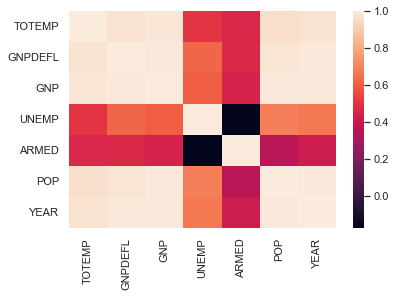

In [265]:
sns.heatmap(df.corr())

Notice a lot of multicollinearity here so you should exclude some of those terms if we want to use linear regression. [Here's an article on why multicollinearity is bad and what you can do about it. ](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Multicollinearity%20occurs%20when%20two%20or,variable%20in%20a%20regression%20model.)

# Linear Regression

* [Statsmodels Docs](https://www.statsmodels.org/devel/regression.html)

Simple example of multiple linear regression with ordinary least squares (the 'vanilla' linear regression). Here I chose *not* to use the R-style formulas for simplicity.

In [152]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]

# Add a constant term if we want to fit an intercept
X = sm.add_constant(X, prepend=True)
# Drop the YEAR column
X = X.drop("YEAR", axis=1)

# Declare/specify the model
mod = sm.OLS(endog=y, exog=X)
# Fit the model
res = mod.fit()
# Present the summary statistics from the fit
res.summary()

/Users/nelsonta/opt/anaconda3/envs/explore_new/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TOTEMP   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     156.4
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           3.70e-09
Time:                        15:15:04   Log-Likelihood:                -117.83
No. Observations:                  16   AIC:                             247.7
Df Residuals:                      10   BIC:                             252.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.246e+04   3.52e+04      2.629      0.025    1.41e+04    1.71e+05
GNPDEFL      -48.4628    132.248     -0.366      0.722    -343.129     246.204
GNP            0.0720      0.032      2.269      0.047       0.001       0.143
UNEMP         -0.4039      0.439     -0.921      0.379      -1.381       0.573
ARMED         -0.5605      0.284     -1.975      0.077      -1.193       0.072
POP           -0.4035      0.330     -1.222      0.250      -1.139       0.332
==============================================================================
Omnibus:                        1.572   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                0.642
Skew:                           0.489   Prob(JB):                        0.725
Kurtosis:                       3.079   Cond. No.                     1.21e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Notice that `statsmodels` called out in note 2 that there is strong multicollinearity, which we saw earlier in the correlation matrix and the heatmap. 

## Dealing with multicollinearity

We'll use VIF to find the variables that contribute the most to the model, borrowing this helper function from [this article](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Multicollinearity%20occurs%20when%20two%20or,variable%20in%20a%20regression%20model.)

In [215]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [218]:
calc_vif(X.iloc[:, 1:])

,variables,VIF
0,GNPDEFL,5209.481637
1,GNP,306.539846
2,UNEMP,37.738499
3,ARMED,39.980260
4,POP,2825.304802


Now that we have a table of VIF values, we will iteratively remove the variable with the highest VIF and recalculate the remaining VIF values, with the goal of getting them as low as possible (ideally <5 as a rule of thumb).

In [256]:
calc_vif(X[["GNP", "UNEMP", "ARMED"]])

,variables,VIF
0,GNP,51.956598
1,UNEMP,22.075676
2,ARMED,17.582863


In [257]:
X[["GNP", "UNEMP", "ARMED"]].corr()

,GNP,UNEMP,ARMED
GNP,1.000000,0.604261,0.446437
UNEMP,0.604261,1.000000,-0.177421
ARMED,0.446437,-0.177421,1.000000


There's still a good amount of multicollinearity going on here, which is not great, and the VIF values are still quite high, but this is good enough to go on.

Next, we'll refit the linear regression with these terms, and making sure to include that constant value.

In [324]:
# Fit the limited model
mod = sm.OLS(endog=y, exog=X[["const", "GNP", "UNEMP", "ARMED"]])
res = mod.fit()
res.summary()

/Users/nelsonta/opt/anaconda3/envs/explore_new/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TOTEMP   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     264.4
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           3.19e-11
Time:                        16:30:37   Log-Likelihood:                -119.16
No. Observations:                  16   AIC:                             246.3
Df Residuals:                      12   BIC:                             249.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.331e+04    716.342     74.415      0.000    5.17e+04    5.49e+04
GNP            0.0408      0.002     18.485      0.000       0.036       0.046
UNEMP         -0.7968      0.213     -3.734      0.003      -1.262      -0.332
ARMED         -0.4828      0.255     -1.892      0.083      -1.039       0.073
==============================================================================
Omnibus:                        4.210   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                1.788
Skew:                           0.532   Prob(JB):                        0.409
Kurtosis:                       4.245   Cond. No.                     2.39e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So we see that the higher the unemployment rate, the lower the total employment rate, which makes sense. We see here and in our EDA that `GNP` is a valuable predictor. However, I would remove `ARMED` because it includes 0 in its confidence interval, indicating that there is a possibility that the actual coefficent may be 0 and that it has no effect on the outcome. So let's do that:

In [267]:
# Refit the model without `ARMED`
mod = sm.OLS(endog=y, exog=X[["const", "GNP", "UNEMP"]])
res = mod.fit()
res.summary()

/Users/nelsonta/opt/anaconda3/envs/explore_new/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TOTEMP   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     329.5
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           7.29e-12
Time:                        15:57:56   Log-Likelihood:                -121.25
No. Observations:                  16   AIC:                             248.5
Df Residuals:                      13   BIC:                             250.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.238e+04    573.550     91.330      0.000    5.11e+04    5.36e+04
GNP            0.0378      0.002     22.120      0.000       0.034       0.042
UNEMP         -0.5436      0.182     -2.987      0.010      -0.937      -0.150
==============================================================================
Omnibus:                        1.922   Durbin-Watson:                   0.976
Prob(Omnibus):                  0.382   Jarque-Bera (JB):                0.677
Skew:                           0.483   Prob(JB):                        0.713
Kurtosis:                       3.288   Cond. No.                     1.75e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

And here we have a good model, though to make it even better we *could* remove `UNEMP` and just do a model with `GNP` and still get a very good model. Determining when to add/subtract terms can be subjective, there are instances in which you would *still* want to keep some terms. 

# AutoRegression (AR)

* [Autoregression Documentation in Statsmodels](https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg)
* An introduction to AR: [Forecasting: Principles and Practice - Autoregressive models](https://otexts.com/fpp3/AR.html)

Next we'll cover *autoregression*, in which we look purely at a single column in our data and try to calculate how well past values relate to future values. 

In [87]:
from statsmodels.tsa.ar_model import AutoReg

<AxesSubplot:xlabel='YEAR'>

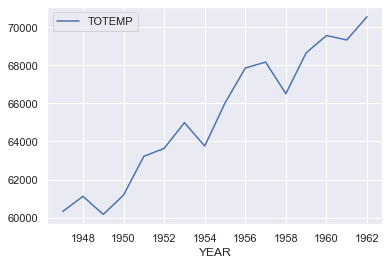

In [268]:
df.plot(x="YEAR", y="TOTEMP")

In [283]:
res = AutoReg(df["TOTEMP"], lags = [1,2,3]).fit()

In [284]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 TOTEMP   No. Observations:                   16
Model:                     AutoReg(3)   Log Likelihood                -107.336
Method:               Conditional MLE   S.D. of innovations            932.311
Date:                Thu, 16 Jun 2022   AIC                            224.672
Time:                        16:01:32   BIC                            227.496
Sample:                             3   HQIC                           224.091
                                   16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6560.1776   5937.908      1.105      0.269   -5077.909    1.82e+04
TOTEMP.L1      0.5232      0.215      2.436      0.015       0.102       0.944
TOTEMP.L2     -0.0685      0.254     -0.269      0.788      -0.567       0.430
TOTEMP.L3      0.4664      0.221      2.107      0.035       0.033       0.900
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0428           -0.0000j            1.0428           -0.0000
AR.2           -0.4479           -1.3621j            1.4339           -0.3006
AR.3           -0.4479           +1.3621j            1.4339            0.3006
-----------------------------------------------------------------------------
"""

# Vector AutoRegression (VAR)

Demonstrate [vector autoregression](https://www.statsmodels.org/devel/vector_ar.html#var-p-processes) with `Statsmodels`. See [Forecasting: Principles and Practice](https://otexts.com/fpp3/VAR.html) for an introduction to VAR.

In [191]:
from statsmodels.tsa.api import VAR

For vector autoregression, instead of having a matrix of X values and a y variable, we are going to measure cross-correlations at various lags. 

In [311]:
var_data = df[["TOTEMP", "GNP", "UNEMP"]]

Next, we call the model fit with `statsmodels` and display the results, similar to what we have done with AR and linear regression before.

In [320]:
var_model = VAR(var_data)
res = var_model.fit(1) # VAR(1) model, i.e. fit up to 2 lags
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Jun, 2022
Time:                     16:17:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    42.6084
Nobs:                     15.0000    HQIC:                   42.0359
Log likelihood:          -367.167    FPE:                1.88710e+18
AIC:                      42.0419    Det(Omega_mle):     9.28555e+17
--------------------------------------------------------------------
Results for equation TOTEMP
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const         54734.286558     30460.800717            1.797           0.072
L1.TOTEMP        -0.050599         0.584557           -0.087           0.931
L1.GNP            0.035032         0.023026            1.521           0.12

We see that the results for equation `TOTEMP` and `UNEMP` are not so good, it appears that the lag-1 data are poor predictors. However, the results for equation `GNP` are more promising, as `L1.GNP` is a good predictor for `GNP`.

So if we wanted to build a predictive model, there is some hope here because we have a reasonable model for `GNP` 1 year in the future, and we can then use that to create a prediction for what `TOTEMP` would be. 

## Reference:

* [Statsmodels official documentation site](https://www.statsmodels.org/stable/index.html)
* [Regression and Linear Models - Statsmodels](https://www.statsmodels.org/devel/user-guide.html#regression-and-linear-models)
* [AutoRegression in Statsmodels](https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg)
* [Forecasting: Principles and Practice - Autoregressive models](https://otexts.com/fpp3/AR.html)
* [Vector Autoregression - Statsmodels](https://www.statsmodels.org/devel/vector_ar.html#var-p-processes)
* [What is multicollinearity? - Analytics Vidya](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Multicollinearity%20occurs%20when%20two%20or,variable%20in%20a%20regression%20model.)
* [Forecasting: Principles and Practice - VAR](https://otexts.com/fpp3/VAR.html)